# Mini Project 3
## A study on formation of echo chambers on social media based on political ideologies 


In [1]:
! pip install networkx
! pip install mesa --quiet 

## Step 1
I import networkx in addition to other libraries and modules imported in class, in order to create graph objects associated with my research question.

In [1]:

from mesa import Model, Agent
from mesa.time import RandomActivation
from mesa.space import SingleGrid
from mesa.visualization import TextVisualization
from mesa.batchrunner import BatchRunner
from IPython.display import HTML
import matplotlib.pyplot as plt
import seaborn as sns
import schelling 
import networkx as nx

## Step 2
The agent and model class are excecuted. I add an additional attribute agent_happy that keeps track of the happiness of every individual agent, since I only want agents to be added to a network when they and their corresponding neighbours are happy during an interaction. I also create two graph objects within the model class that keep track of the two separate networks of liberals and conservatives.

In [76]:
class SchellingAgent(Agent):
    """
    Schelling segregation agent
    """

    def __init__(self, pos, model, agent_type):
        """
        Create a new Schelling agent.

        Args:
           pos (x, y): Agent initial location.
           agent_type: Indicator for the agent's type (minority=1, majority=0)
        """
        super().__init__(pos, model) 
        self.pos = pos
        self.type = agent_type
        self.agent_happy = 0
    def step(self):
        similar = 0
        for neighbor in self.model.grid.neighbor_iter(self.pos):
            if neighbor.type == self.type:
                similar += 1
        if similar < self.model.homophily:
        
            self.model.grid.move_to_empty(self)
        else:
            self.agent_happy = 1
            for neighbor in self.model.grid.neighbor_iter(self.pos):
                if neighbor.agent_happy ==1:
                    if self.type == 1 and neighbor.type ==1: 
                    
                         self.model.graph_1.add_edge(neighbor,self)
                    elif self.type == 0 and neighbor.type == 0:
                        self.model.graph_2.add_edge(neighbor,self)
                        
            self.model.happy += 1


class SchellingModel(Model):
    """
    Model class for the Schelling segregation model.
    """

    def __init__(self, height=20, width=20, density=0.5, minority_pc=0.5, homophily=3):
        """ """

        self.height = height
        self.width = width
        self.density = density
        self.minority_pc = minority_pc
        self.homophily = homophily
        self.graph_1 = nx.Graph()
        self.graph_2 = nx.Graph()

        self.schedule = RandomActivation(self)
        self.grid = SingleGrid(width, height, torus=True)

        self.happy = 0

        for cell in self.grid.coord_iter():
            x = cell[1]
            y = cell[2]
            if self.random.random() < self.density:
                if self.random.random() < self.minority_pc:
                    agent_type = 1
                else:
                    agent_type = 0

                agent = SchellingAgent((x, y), self, agent_type)
                self.grid.position_agent(agent, (x, y))
                self.schedule.add(agent)
        self.running = True

    def step(self):
        """
        Run one step of the model. If all agents are happy, halt the model.
        """
        self.happy = 0  
        self.schedule.step()

        if self.happy == self.schedule.get_agent_count():
            self.running = False

## Step 3
I run the simulation and draw the two graph objects and print out the number of nodes in each at the end of the simulation to cross check that their sum is equak to the number of happy agents at the end of the simulation.

Number of Happy Agents: 87
Number of Happy Agents: 113
Number of Happy Agents: 147
Number of Happy Agents: 166
Number of Happy Agents: 169


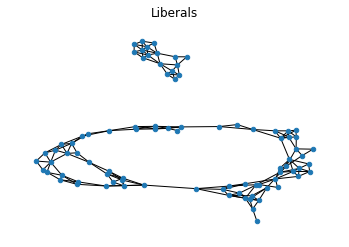

In [94]:
model = SchellingModel()
for i in range(5):
    model.step()
   
    
    print('Number of Happy Agents:', model.happy)
ax_1 = plt.gca()

ax_1.set_title('Liberals')
nx.draw(model.graph_1,with_labels=False, font_weight='bold', node_size = 20, ax=ax_1)


In [95]:
model.graph_1.number_of_nodes()

88

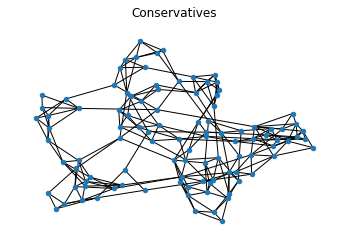

In [96]:
ax_2 = plt.gca()
ax_2.set_title('Conservatives')
nx.draw(model.graph_2,with_labels=False, font_weight='bold', node_size = 20, ax = ax_2)


In [92]:
model.graph_2.number_of_nodes()

79

## Step 4
A dynamic visual that shows changes with time is created.

In [12]:
ani = schelling.animate(SchellingModel())
HTML(ani.to_jshtml())

## Step 5
Multiple simulations are run for different levels of homophily which I then use to create a violin plot that displays how proportions of agents in segregated echo chambers changes with different levels of homophily.

In [100]:
fixed_params = {"height": 20, "width": 20, "density": 0.8, "minority_pc": 0.5} 
variable_parms = {"homophily": range(1, 6)}
model_reporters = {"Segregated_Agents": schelling.get_segregation}

param_sweep = BatchRunner(SchellingModel,
                          variable_parameters=variable_parms,
                          fixed_parameters=fixed_params,
                          iterations=10,
                          max_steps=200,
                          model_reporters=model_reporters)

In [101]:
param_sweep.run_all() 

50it [00:11,  4.42it/s]


In [102]:
df = param_sweep.get_model_vars_dataframe()
df.head()

,homophily,Run,Segregated_Agents,height,width,density,minority_pc
0,1,0,0.038835,20,20,0.8,0.5
1,1,1,0.022013,20,20,0.8,0.5
2,1,2,0.028213,20,20,0.8,0.5
3,1,3,0.021605,20,20,0.8,0.5
4,1,4,0.021875,20,20,0.8,0.5


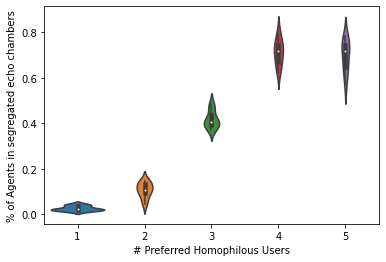

In [104]:
sns.violinplot(x='homophily', y='Segregated_Agents', data=df)
plt.xlabel('# Preferred Homophilous Users')
plt.ylabel('% of Agents in segregated echo chambers');